In [1]:
library(tidyverse)
library(Seurat)
library(Signac)
library(future)%>% suppressMessages()
plan("multicore",workers=10)
library(EnsDb.Mmusculus.v79)%>% suppressMessages()
library(BSgenome.Mmusculus.UCSC.mm10)%>% suppressMessages()
library(patchwork)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.4 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




## Create Object

In [12]:
metadata_hic = read_tsv("../data/metadata/metadata_hic.tsv")
metadata_enrich = read_tsv("../data/metadata/metadata_enrich.tsv") %>% 
        dplyr::select(cellname,UMIs_gene,genes_gene,UMIs_exon,genes_exon,UMIs_gene_genome1,genes_gene_genome1,
               UMIs_gene_genome2,genes_gene_genome2,ct_reads,atac_reads,nCount_atac,nCount_ct,TSS.enrichment.atac,TSS.enrichment.ct)

Rows: 4416 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): cellname
dbl (17): Rawreads, yperx, raw_pairs, pairs_dedup, pairs_clean1, pairs_clean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4416 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): cellname
dbl (28): Rawreads, DNAreads, RNAreads, yperx, raw_pairs, pairs_dedup, pairs...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
metadata = metadata_hic %>% left_join(metadata_enrich)

Joining with `by = join_by(cellname)`


In [15]:
metadata %>% dplyr::filter(pairs_clean3 > 50000,nCount_atac>1000,nCount_ct > 1000,UMIs_gene > 500) -> metadata_qcpass
cellnames_qcpass = metadata_qcpass$cellname

In [5]:
rnamat = read_tsv("../data/RNA/counts.gene.total.format.tsv.gz") %>% column_to_rownames("gene") %>% dplyr::select(all_of(cellnames_qcpass)) %>% as.matrix()
rnamat %>% CreateSeuratObject(counts = ., project = "CHARM",min.features = 1) -> charm

Rows: 41740 Columns: 4415
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr    (1): gene
dbl (4414): R1P10001, R1P10002, R1P10003, R1P10004, R1P10005, R1P10006, R1P1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


In [6]:
charm@meta.data %>% mutate(cellname = rownames(.),temp=cellname) %>% 
    left_join(metadata_qcpass %>% dplyr::select(1:18), by = "cellname") %>% column_to_rownames("temp") -> charm@meta.data

In [7]:
atac_fragments = CreateFragmentObject("../data/fragments/atac.fragments.bgz",cells = cellnames_qcpass)
ct_fragments = CreateFragmentObject("../data/fragments/ct.fragments.bgz",cells = cellnames_qcpass)
mm10gnme <- seqlengths(BSgenome.Mmusculus.UCSC.mm10)
atac_count_matrix = GenomeBinMatrix(atac_fragments,binsize = 5000,genome = mm10gnme)
ct_count_matrix = GenomeBinMatrix(ct_fragments,binsize = 5000,genome = mm10gnme)

atac_assay <- CreateChromatinAssay(counts = atac_count_matrix, fragments = atac_fragments, genome = "mm10")
ct_assay <- CreateChromatinAssay(counts = ct_count_matrix, fragments = ct_fragments, genome = "mm10")

charm[["atac"]] <- atac_assay
charm[["ct"]] <- ct_assay

Computing hash

Computing hash

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [75]:
peaks %>% as.data.frame() %>% dplyr::select(1:3) %>% write_tsv("CHARMbrain.h3k27ac.bed",col_names = FALSE)

In [8]:
macs2_path <- "/home/zliu/miniforge3/envs/charm/bin/macs2"
# callpeak and calculate FRiP
DefaultAssay(charm) <- "atac"
# process atac using peak strategy
# call peaks using MACS2
peaks <- CallPeaks(
    charm,
    assay="atac",
    broad = FALSE,
    macs2.path = macs2_path,
    extsize = 200, 
    effective.genome.size = "mm",
    additional.args = "--shift 0"
)
# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks <- keepStandardChromosomes(peaks, pruning.mode = "coarse")
peaks <- subsetByOverlaps(x = peaks, ranges = blacklist_mm10, invert = TRUE)

annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "mm10"

macs2_counts <- FeatureMatrix(
  fragments = Fragments(charm),
  features = peaks,
  cells = colnames(charm)
)
charm[["atac_peaks"]] <- CreateChromatinAssay(
  counts = macs2_counts,
  fragments = "../data/fragments/atac.fragments.bgz",
  annotation = annotations
)

DefaultAssay(charm) <- "ct"
# process atac using peak strategy
# call peaks using MACS2
peaks <- CallPeaks(
  object = charm,  
  assay = "ct", 
  macs2.path = macs2_path,
  broad = TRUE,  
  extsize = 200,  
  effective.genome.size = "mm",  
  additional.args = "--nomodel --nolambda --broad-cutoff 0.1 --bdg --shift 0"
)
# remove peaks on nonstandard chromosomes and in genomic blacklist regions
peaks <- keepStandardChromosomes(peaks, pruning.mode = "coarse")
peaks <- subsetByOverlaps(x = peaks, ranges = blacklist_mm10, invert = TRUE)

annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "mm10"

macs2_counts <- FeatureMatrix(
  fragments = Fragments(charm),
  features = peaks,
  cells = colnames(charm)
)
charm[["ct_peaks"]] <- CreateChromatinAssay(
  counts = macs2_counts,
  fragments = "../data/fragments/ct.fragments.bgz",
  annotation = annotations
)

charm = FRiP(charm,"atac_peaks","nCount_atac",col.name="FRiP_atac",verbose=FALSE)
charm = FRiP(charm,"ct_peaks","nCount_ct",col.name="FRiP_ct",verbose=FALSE)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [9]:
DefaultAssay(charm) <- "RNA"
charm %>% SCTransform(verbose = FALSE) %>% RunPCA(verbose=FALSE) -> charm
charm %>% RunUMAP(dims = 1:20, verbose = FALSE) -> charm
charm  %>% FindNeighbors(dims = 1:20) %>% FindClusters() -> charm

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4265
Number of edges: 129039

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9267
Number of communities: 22
Elapsed time: 0 seconds


Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."


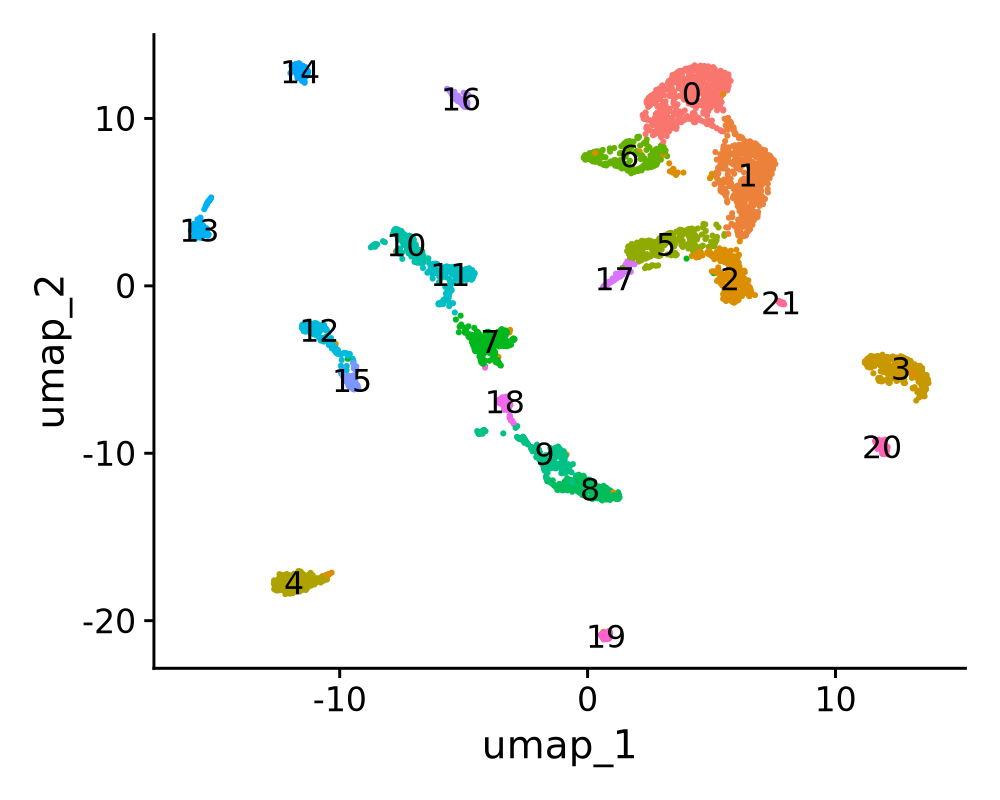

In [10]:
options(repr.plot.width=5, repr.plot.height=4,repr.plot.res=200)
DimPlot(charm,label = TRUE) + NoLegend()

In [11]:
charm[[]] %>% mutate(mouse = substr(cellname,1,2)) -> charm@meta.data

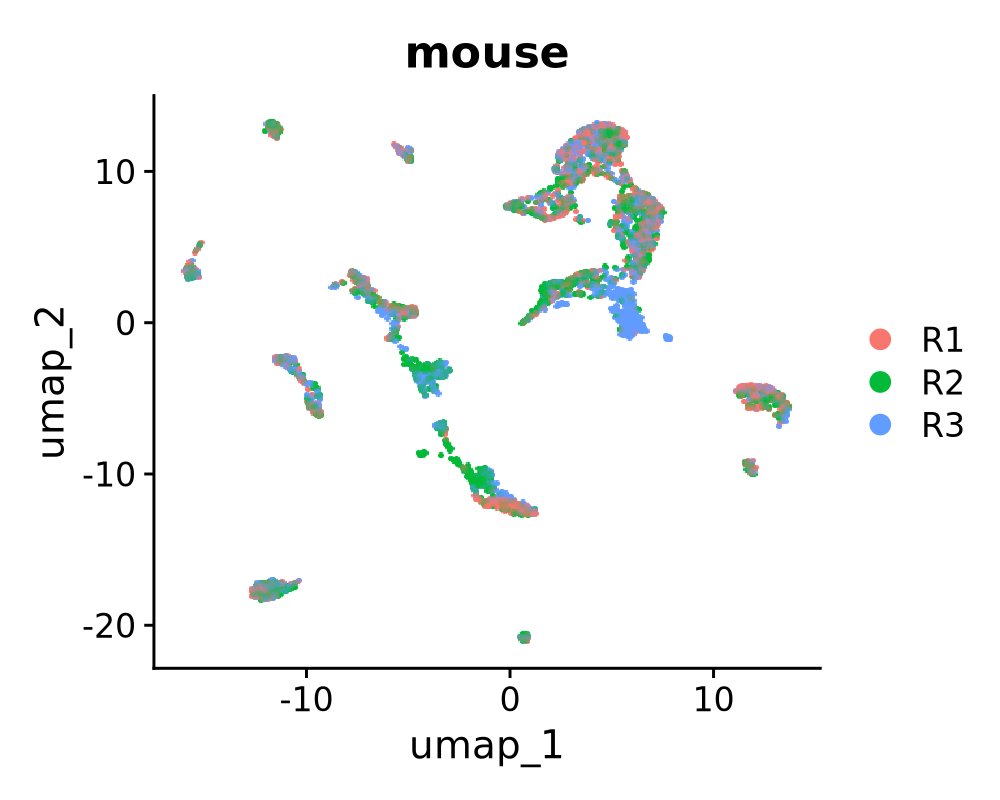

In [12]:
options(repr.plot.width=5, repr.plot.height=4,repr.plot.res=200)
DimPlot(charm,group.by = "mouse",raster=TRUE, pt.size = 3)

`summarise()` has grouped output by 'seurat_clusters'. You can override using the `.groups` argument.


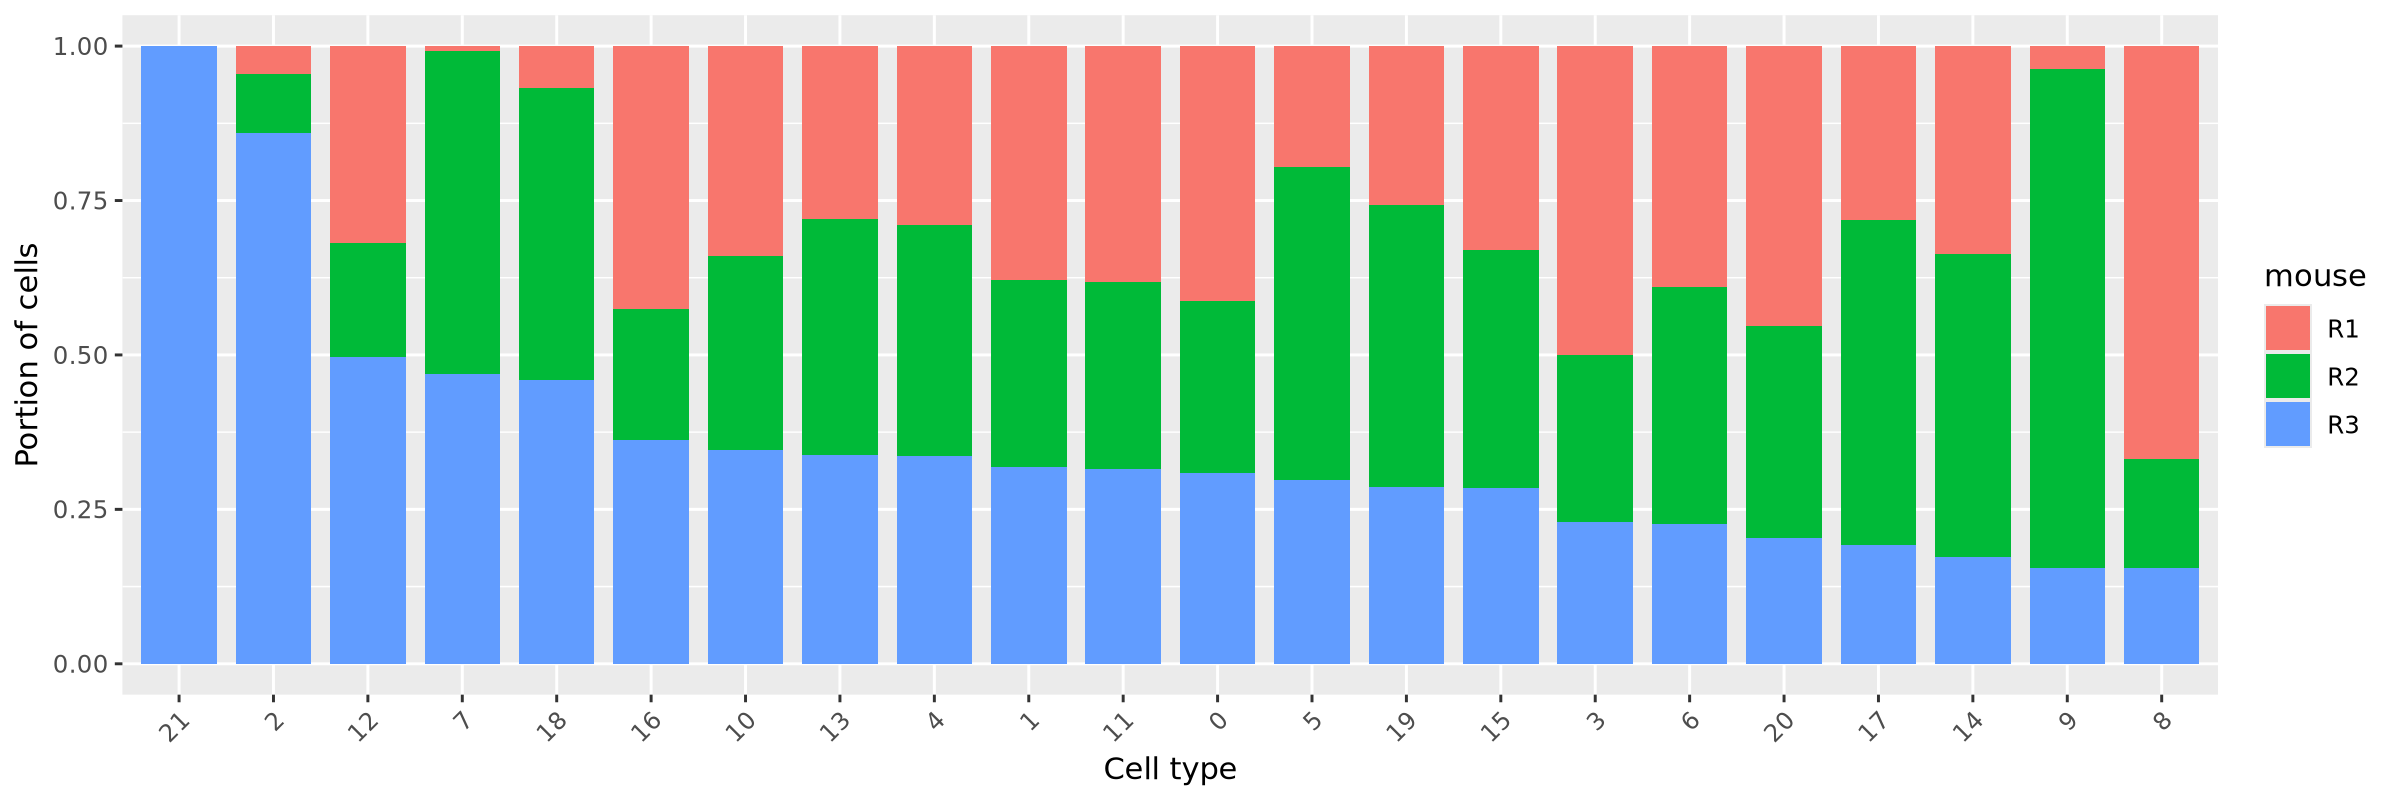

In [14]:
options(repr.plot.height=4,repr.plot.width=12,repr.plot.res=200)
charm[[]] %>% 
  dplyr::select(seurat_clusters, mouse) %>% 
  group_by(seurat_clusters, mouse) %>% 
  summarise(n = n()) %>% 
  group_by(seurat_clusters) %>% 
  mutate(p = n/sum(n)) %>% 
  # 按 R3 的比例排序
  mutate(r3_rank = ifelse(mouse == "R3", p, 0)) %>% 
  arrange(-r3_rank) -> pdata
order_celltype = pdata%>% dplyr::filter(mouse == "R3") %>% pull(seurat_clusters)
pdata$seurat_clusters = factor(pdata$seurat_clusters, levels = order_celltype)

pdata %>% 
  ggplot(aes(x = seurat_clusters, y = p, fill = mouse)) + 
  geom_bar(stat = "identity", width = 0.8) + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
  ylab("Portion of cells") + 
  xlab("Cell type") 

In [ ]:
# `%nin%` <- Negate(`%in%`)
# charm = subset(charm, subset = seurat_clusters %nin% c("21","2","7"))

# DefaultAssay(charm) <- "RNA"
# charm %>% SCTransform(verbose = FALSE) %>% RunPCA(verbose=FALSE) -> charm
# charm %>% RunUMAP(dims = 1:20, verbose = FALSE) -> charm
# charm  %>% FindNeighbors(dims = 1:20) %>% FindClusters() -> charm

## ATAC & Cut&Tag

In [15]:
DefaultAssay(charm) = "atac_peaks"
charm %>% RunTFIDF() %>% FindTopFeatures(min.cutoff='q0') %>% 
    RunSVD(reduction.name="atac_peaks_svd",verbose=FALSE) -> charm
charm  %>% RunUMAP(reduction = "atac_peaks_svd",dims = 2:20,verbose=FALSE,reduction.name = "atac_peaks_umap") -> charm

DefaultAssay(charm) = "ct_peaks"
charm %>% RunTFIDF() %>% FindTopFeatures(min.cutoff='q0') %>% 
    RunSVD(reduction.name="ct_peaks_svd",verbose=FALSE) -> charm
charm  %>% RunUMAP(reduction = "ct_peaks_svd",dims = 2:20,verbose=FALSE,reduction.name = "ct_peaks_umap") -> charm

# dim reduction and umap for atac
DefaultAssay(charm) <- "atac"
charm <- RunTFIDF(charm)
charm <- FindTopFeatures(charm, min.cutoff = 'q0')
charm <- RunSVD(object = charm,reduction.name = "atac_svd")
charm = RunUMAP(charm, reduction = "atac_svd", dims = 2:20, verbose = FALSE,reduction.name = "atac_umap")

DefaultAssay(charm) <- "ct"
charm <- RunTFIDF(charm)
charm <- FindTopFeatures(charm, min.cutoff = 'q0')
charm <- RunSVD(object = charm,reduction.name = "ct_svd")
charm = RunUMAP(charm, reduction = "ct_svd", dims = 2:20, verbose = FALSE,reduction.name = "ct_umap")

Performing TF-IDF normalization

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Performing TF-IDF normalization

Warning message:
"Key 'LSI_' taken, using 'ctpeakssvd_' instead"
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Warning message:
"Key 'LSI_' taken, using 'atacsvd_' instead"
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "

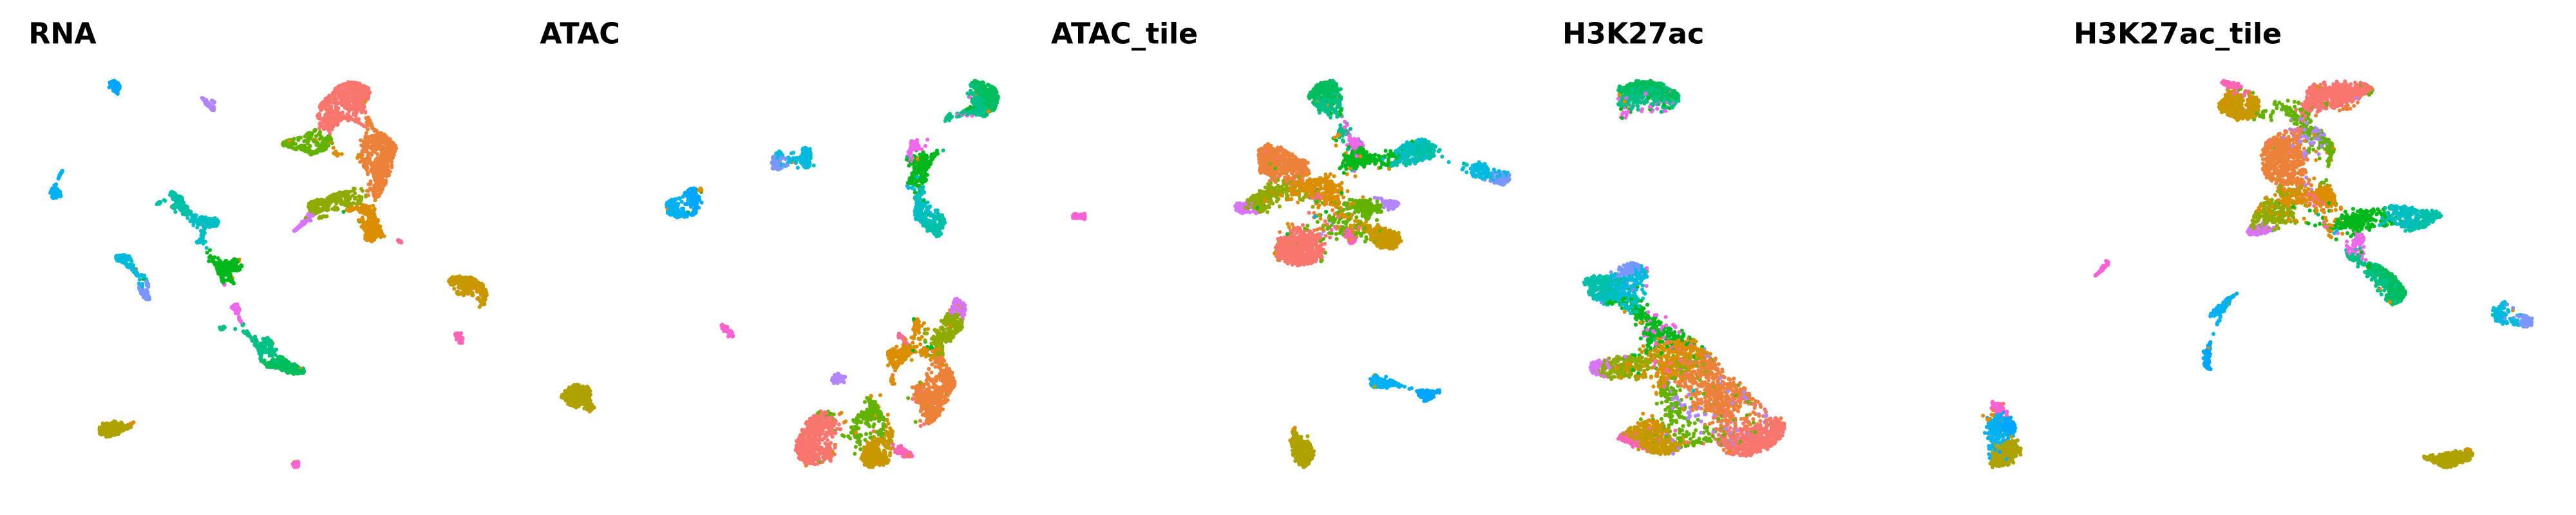

In [16]:
options(repr.plot.width=20, repr.plot.height=4,repr.plot.res=200)
a = DimPlot(charm,reduction="umap") + ggtitle("RNA")
b = DimPlot(charm,reduction="atac_peaks_umap")+ ggtitle("ATAC") 
c = DimPlot(charm,reduction="atac_umap")+ ggtitle("ATAC_tile")
d = DimPlot(charm,reduction="ct_peaks_umap")+ ggtitle("H3K27ac")
e = DimPlot(charm,reduction="ct_umap")+ ggtitle("H3K27ac_tile")

(a|b|c|d|e) & NoAxes() & NoLegend()

In [17]:
charm

An object of class Seurat 
1546748 features across 4265 samples within 6 assays 
Active assay: ct (545118 features, 545118 variable features)
 2 layers present: counts, data
 5 other assays present: RNA, atac, atac_peaks, ct_peaks, SCT
 10 dimensional reductions calculated: pca, umap, atac_peaks_svd, atac_peaks_umap, ct_peaks_svd, ct_peaks_umap, atac_svd, atac_umap, ct_svd, ct_umap

In [24]:
charm %>% saveRDS("charm.rds")

## RNA annotation

In [18]:
P56_cortex = readRDS("../zhong2024.P56_cortex.rds")
#charm = readRDS("charm.rds")

In [19]:
DefaultAssay(charm) = "SCT"
charm
P56_cortex

An object of class Seurat 
1546748 features across 4265 samples within 6 assays 
Active assay: SCT (29393 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 5 other assays present: RNA, atac, ct, atac_peaks, ct_peaks
 10 dimensional reductions calculated: pca, umap, atac_peaks_svd, atac_peaks_umap, ct_peaks_svd, ct_peaks_umap, atac_svd, atac_umap, ct_svd, ct_umap

An object of class Seurat 
37094 features across 34323 samples within 2 assays 
Active assay: SCT (17094 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne
 1 spatial field of view present: fov

In [20]:
anchors <- FindTransferAnchors(reference = P56_cortex, query = charm, dims = 1:30,reduction = "pcaproject",verbose = FALSE)

Warning message in ValidateParams_FindTransferAnchors(reference = reference, query = query, :
"Both reference and query assays have been processed with SCTransform.Setting normalization.method = 'SCT' and continuing."
Warning message:
"No layers found matching search pattern provided"


In [21]:
celltype_predict = TransferData(anchorset = anchors,refdata = P56_cortex$majortype)
charm <- AddMetaData(object = charm, metadata = celltype_predict %>% dplyr::select(predicted.id))

Finding integration vectors

Finding integration vector weights

Predicting cell labels



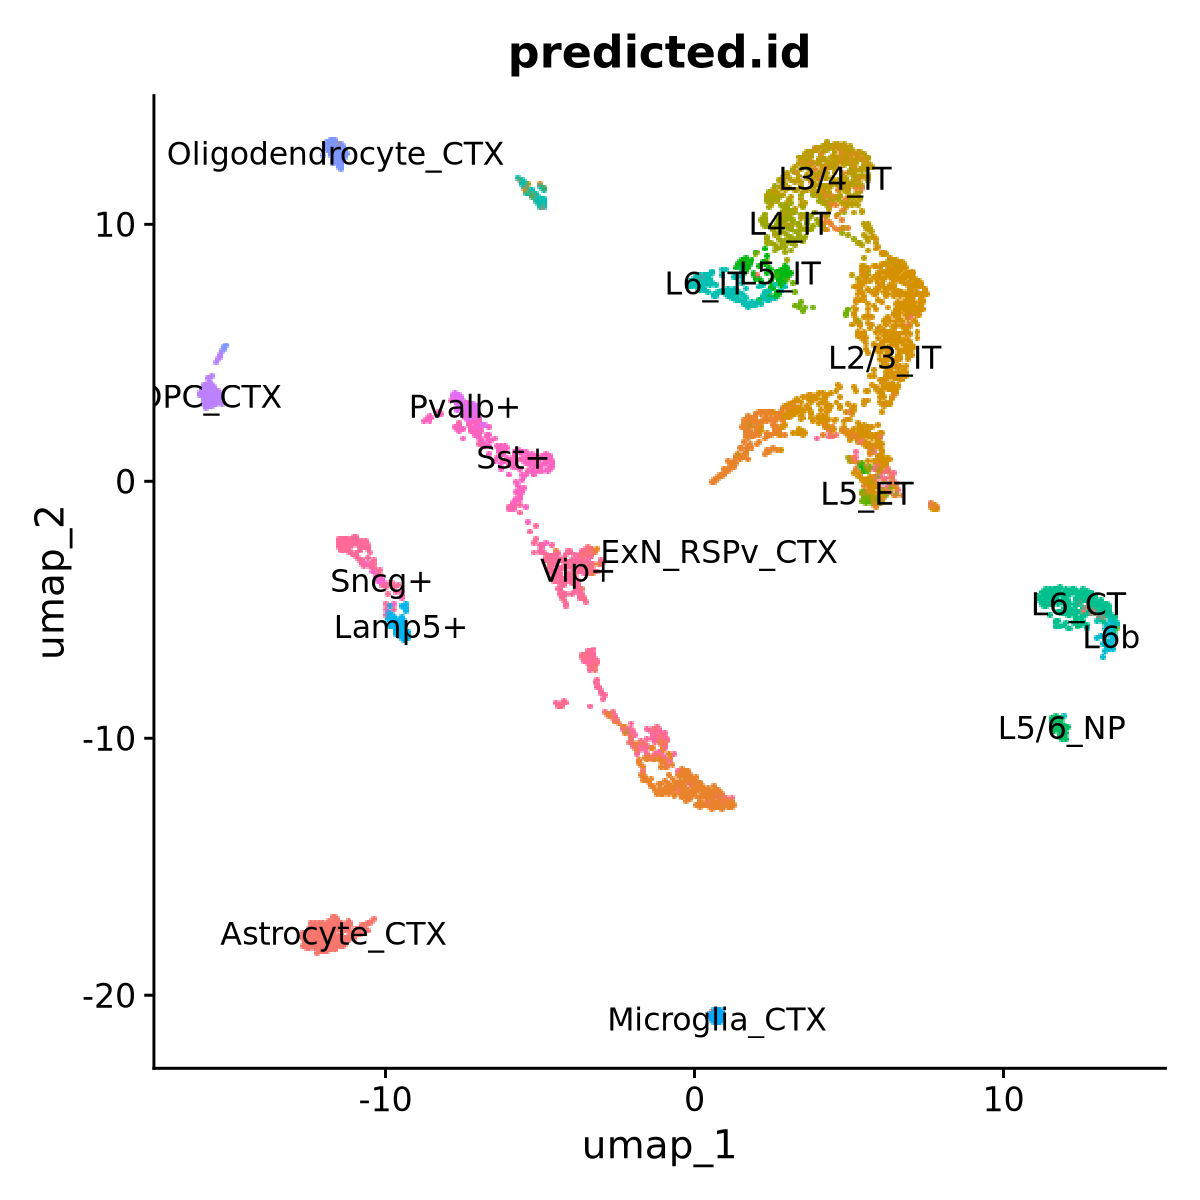

In [26]:
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=200)
DimPlot(charm,group.by = "predicted.id",label = T,reduction="umap",raster=T,pt.size = 2) + NoLegend()

In [27]:
DPT_cortex = readRDS("/zliu_ssd/CHARM/linkCRE/droplet_pairtag/DPT_brain.rds")

In [31]:
anchors <- FindTransferAnchors(reference = DPT_cortex, query = charm, dims = 1:30,reduction = "pcaproject",verbose = FALSE)
celltype_predict = TransferData(anchorset = anchors,refdata = DPT_cortex$Anno0.8_yel)
charm <- AddMetaData(object = charm, metadata = celltype_predict %>% mutate(predicted.id.dpt = predicted.id) %>% dplyr::select(predicted.id.dpt))

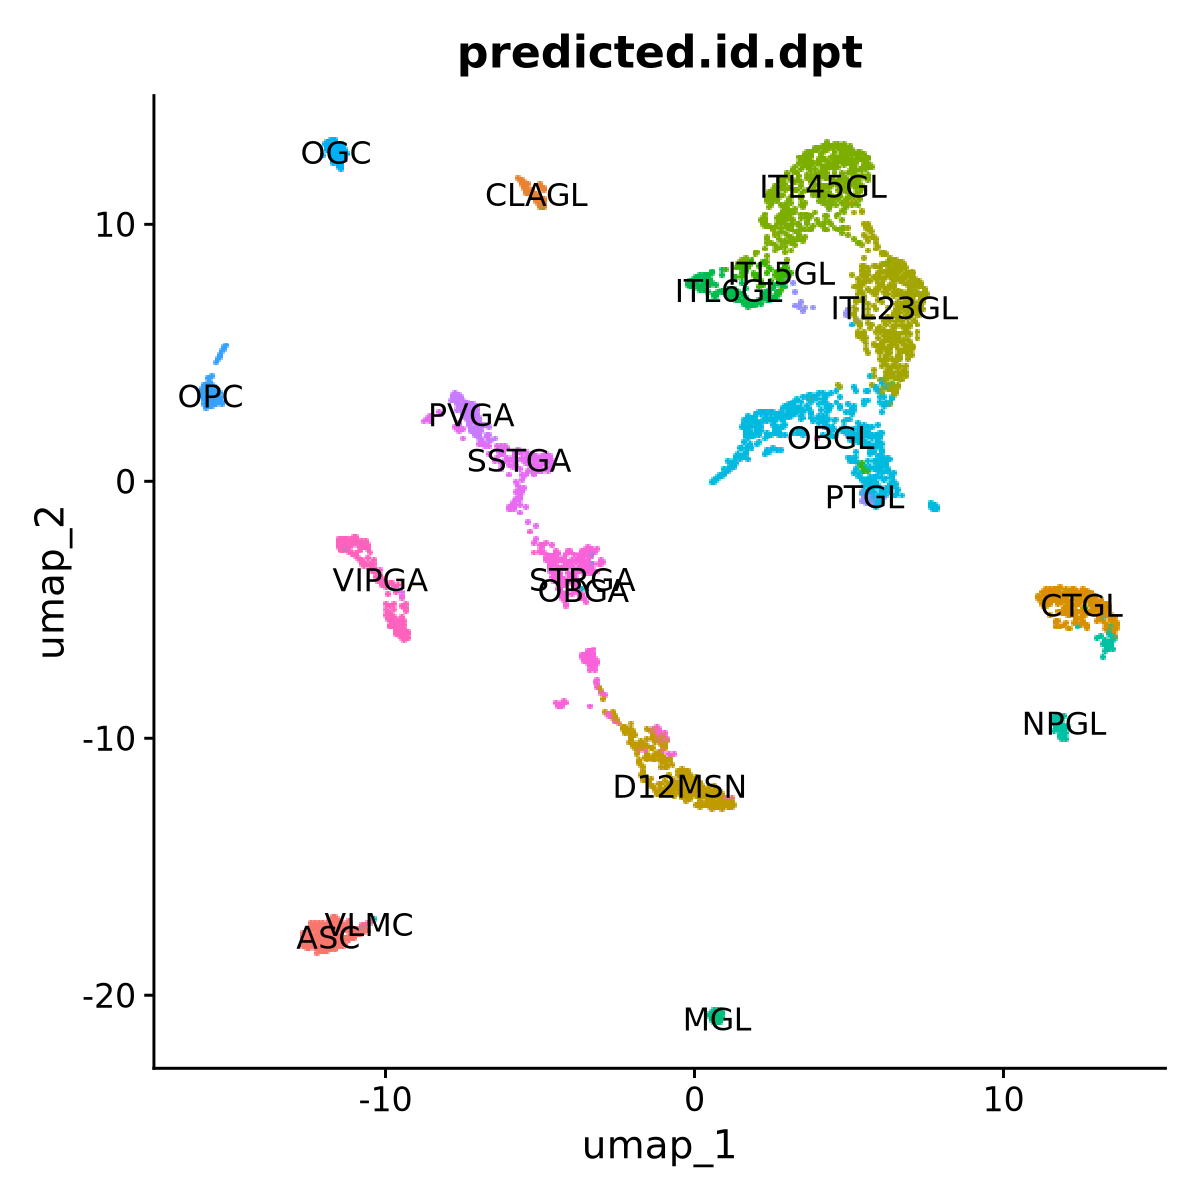

In [32]:
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=200)
DimPlot(charm,group.by = "predicted.id.dpt",label = T,reduction="umap",raster=T,pt.size = 2) + NoLegend()

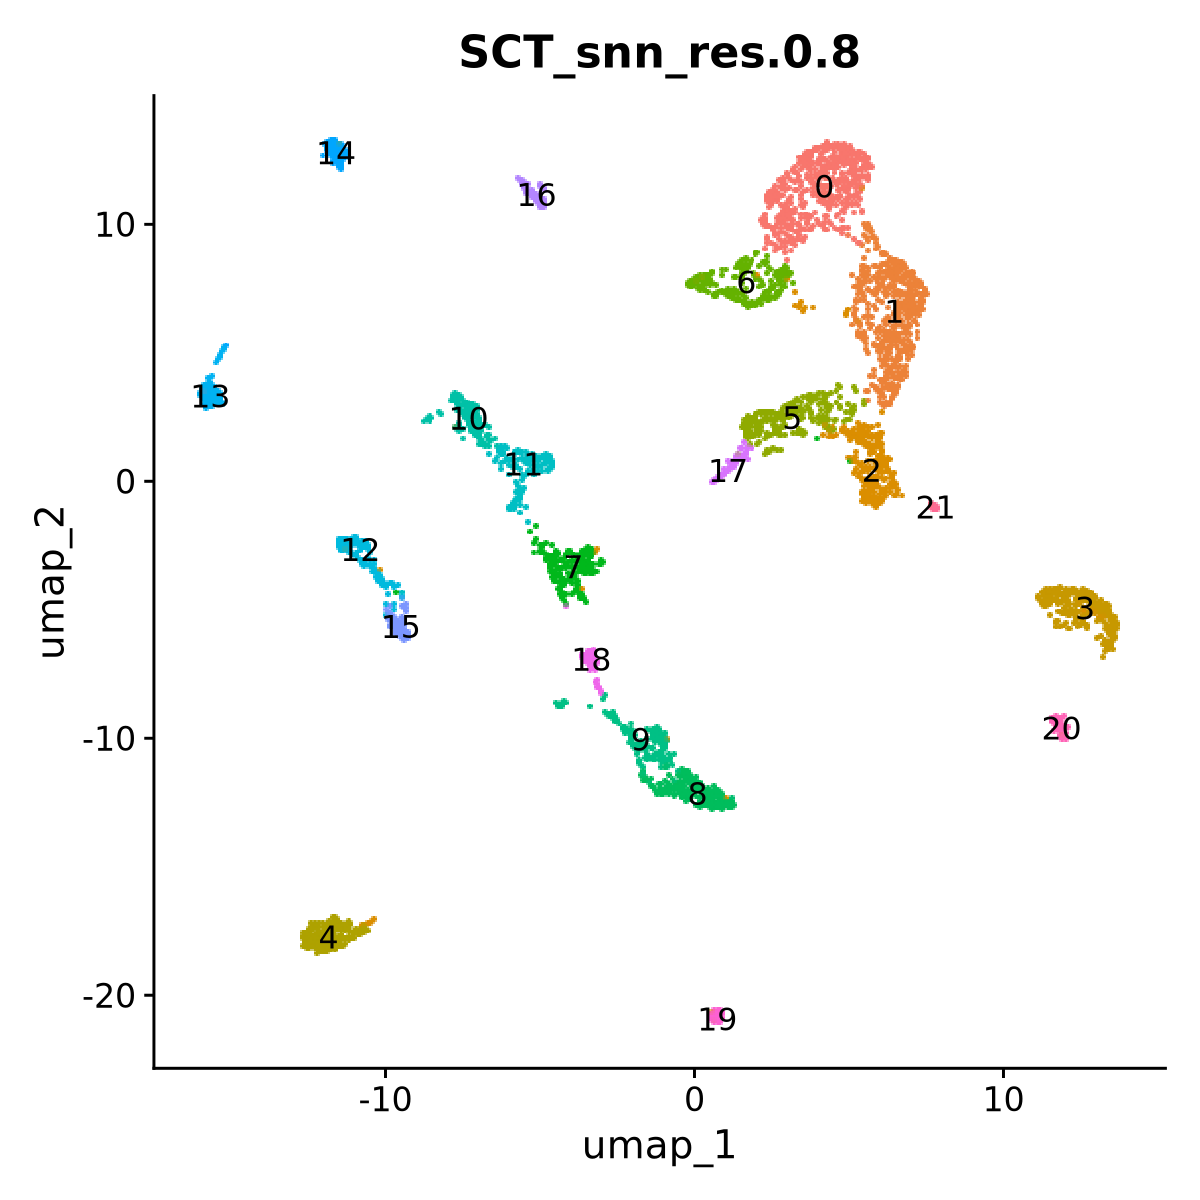

In [36]:
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=200)
DimPlot(charm,group.by = "SCT_snn_res.0.8",label = T,reduction="umap",raster=T,pt.size = 2) + NoLegend()

In [ ]:
markers = FindAllMarkers(charm)

In [54]:
annotation <- data.frame(
  SCT_snn_res.0.8 = factor(0:21), 
  celltype = c("Ex_L3/4_IT",          # 0
               "Ex_L2/3_IT",          # 1
               "Ex_Unknown1",         # 2
               "Ex_L6_CT",            # 3
               "Ast",                 # 4
               "Ex_OB",               # 5
               "Ex_L5/6_IT",          # 6
               "Inh_Unknown1",         # 7
               "Inh_MSN",             # 8
               "Inh_MSN",             # 9
               "Inh_Pvalb",           # 10
               "Inh_Sst",             # 11
               "Inh_Vip",             # 12
               "OPC",                 # 13
               "ODC",                 # 14
               "Inh_Ndnf/Lamp5",      # 15
               "Ex_CL",               # 16
               "Ex_OB",               # 17
               "Inh_Unknown2",        # 18
               "Microglia",           # 19
               "Ex_L5/6_NP",          # 20
               "Ex_Unknown2")         # 21
)
charm@meta.data %>% left_join(annotation) %>% mutate(temp=cellname) %>% column_to_rownames("temp") -> charm@meta.data

Joining with `by = join_by(SCT_snn_res.0.8)`


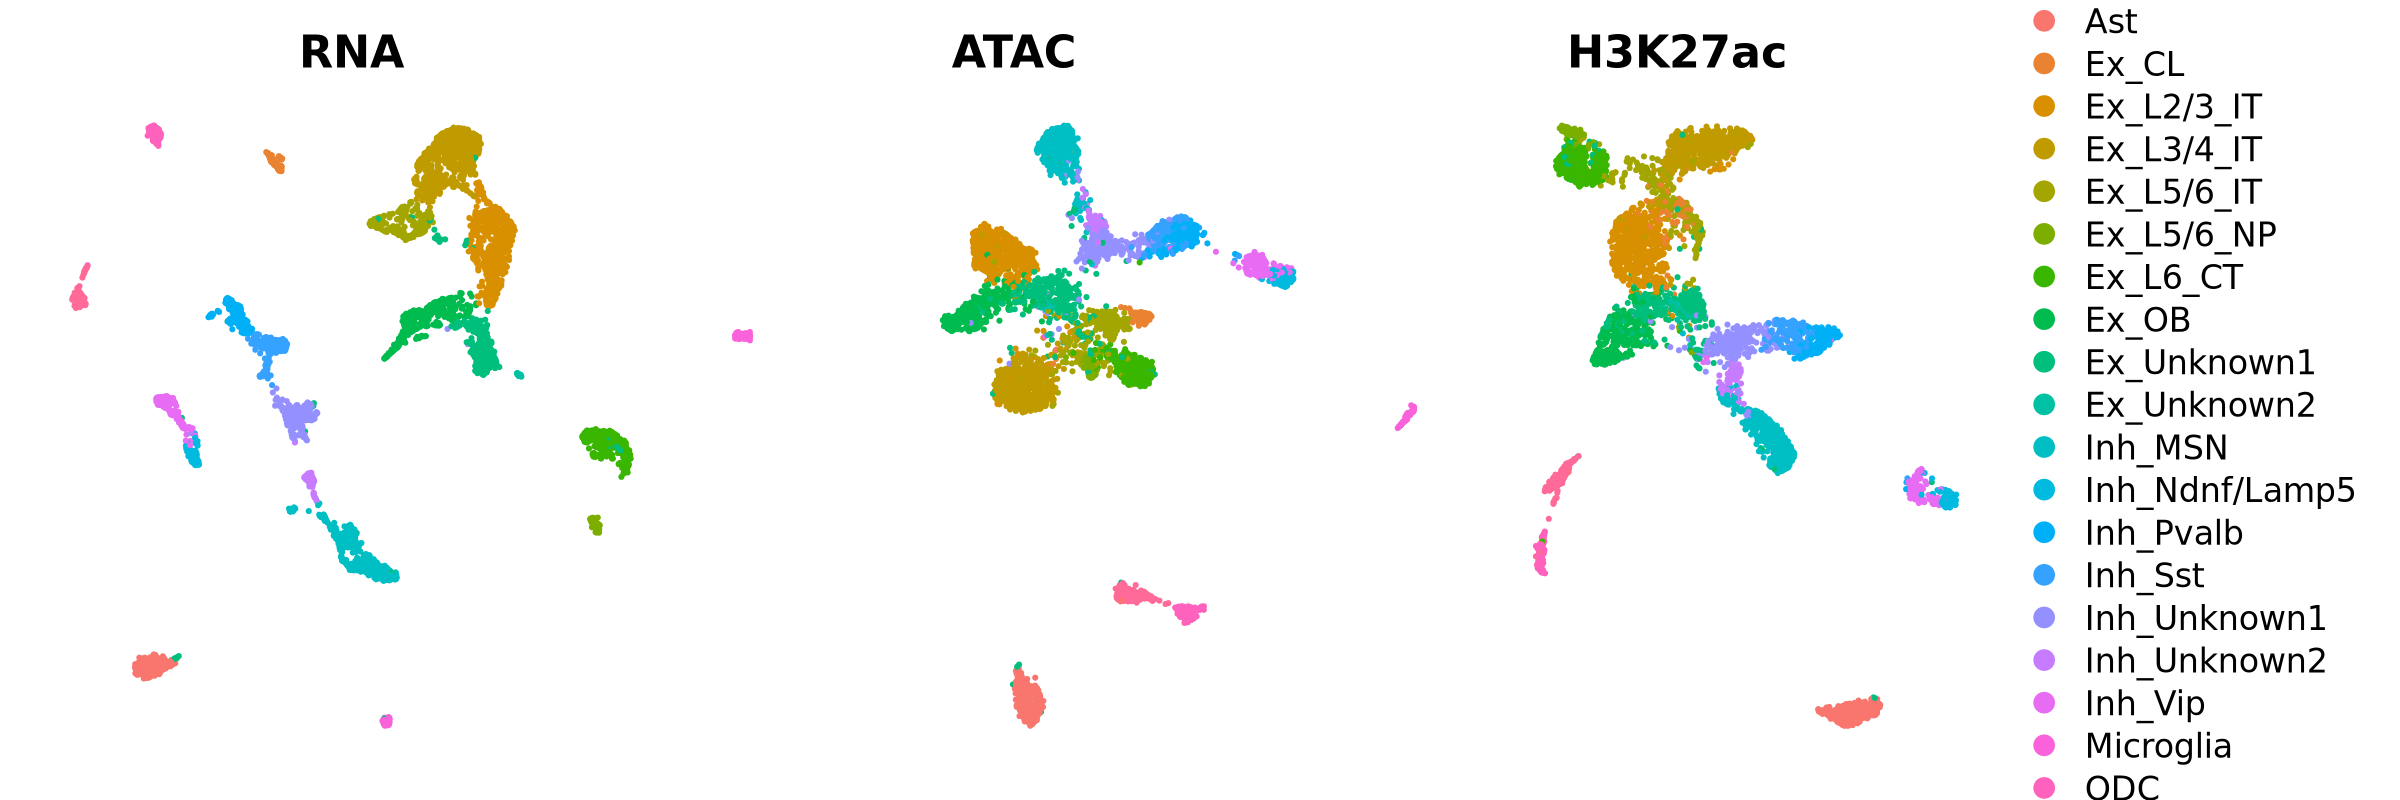

In [55]:
options(repr.plot.width=12, repr.plot.height=4,repr.plot.res=200)
a = DimPlot(charm,reduction="umap",group.by = "celltype") + ggtitle("RNA")
b = DimPlot(charm,reduction="atac_umap",group.by = "celltype")+ ggtitle("ATAC")
c = DimPlot(charm,reduction="ct_umap",group.by = "celltype")+ ggtitle("H3K27ac")

(a& NoLegend()|b& NoLegend()|c) & NoAxes() 

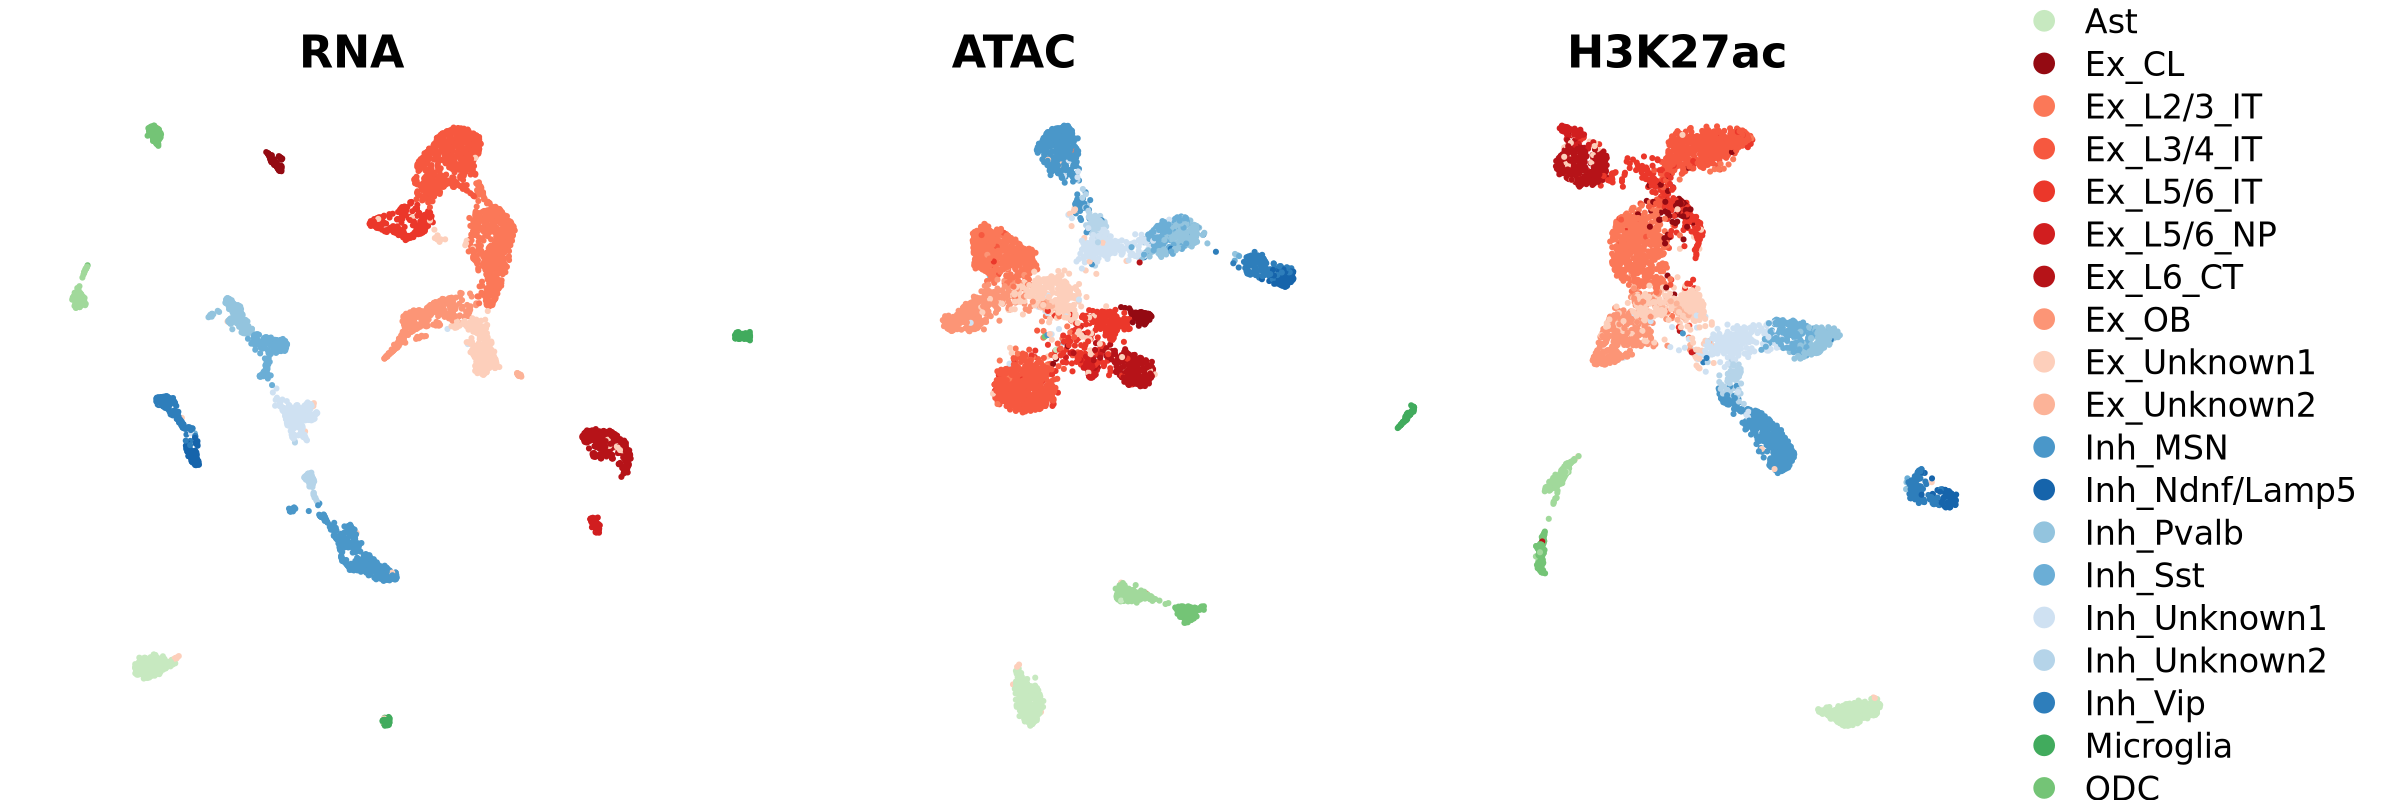

In [64]:
library(RColorBrewer)
get_optimized_colors <- function(palette, n) {
  colorRampPalette(brewer.pal(9, palette))(max(n, 9))[seq_len(n)] # 确保最小取色数
}
excitatory_colors <- get_optimized_colors("Reds", 12)[3:12]  
inhibitory_colors <- get_optimized_colors("Blues", 11)[3:12] 
glia_colors <- get_optimized_colors("Greens", 7)[3:6]     


celltype_colors <- c(
  "Ex_Unknown1" = excitatory_colors[1], 
  "Ex_Unknown2" = excitatory_colors[2],
  "Ex_OB" = excitatory_colors[3],
  "Ex_L2/3_IT" = excitatory_colors[4],
  "Ex_L3/4_IT" = excitatory_colors[5],
  "Ex_L5/6_IT" = excitatory_colors[6],
  "Ex_L5/6_NP" = excitatory_colors[7],
  "Ex_L6_CT" = excitatory_colors[8],   
  "Ex_CL" = excitatory_colors[9],
  
  # 抑制性神经元（7类）
  "Inh_Unknown1" = inhibitory_colors[1],
  "Inh_Unknown2" = inhibitory_colors[2],
  "Inh_Pvalb" = inhibitory_colors[3],
  "Inh_Sst" = inhibitory_colors[4],  
  "Inh_MSN" = inhibitory_colors[5], 
  "Inh_Vip" = inhibitory_colors[6],
  "Inh_Ndnf/Lamp5" = inhibitory_colors[7],
  
  # 胶质细胞（4类）
  "Ast" = glia_colors[1],
  "OPC" = glia_colors[2],
  "ODC" = glia_colors[3],
  "Microglia" = glia_colors[4]
)

options(repr.plot.width=12, repr.plot.height=4,repr.plot.res=200)
a = DimPlot(charm, reduction="umap", group.by = "celltype", cols = celltype_colors) + ggtitle("RNA")
b = DimPlot(charm, reduction="atac_umap", group.by = "celltype", cols = celltype_colors) + ggtitle("ATAC")
c = DimPlot(charm, reduction="ct_umap", group.by = "celltype", cols = celltype_colors) + ggtitle("H3K27ac")

(a & NoLegend() | b & NoLegend() | c) & NoAxes()

In [65]:
charm[[]] %>% dplyr::select(cellname) %>% write_tsv("qcpass_cellnames.txt",col_names = FALSE)

In [66]:
charm[[]] %>% write_tsv("metadata.tsv")

In [67]:
charm %>% saveRDS("charm.rds")

## Add schicluster embedding

In [29]:
#charm <- readRDS("charm.rds")

In [76]:
sch_embedding = rhdf5::h5read("./schicluster_embedding/imputed_matrix/100kb_resolution/merged/embed/pad1_std1_rp0.5_sqrtvc.svd100.hdf5","data")
sch_embedding = t(sch_embedding)
rownames(sch_embedding) = colnames(charm)
charm[["schiclsuter"]] = CreateDimReducObject(embeddings = sch_embedding,assay = "schicluster",key="SCHICLUSTER_")

Warning message:
"No columnames present in cell embeddings, setting to 'SCHICLUSTER_1:100'"
Warning message:
"Adding a dimensional reduction (schiclsuter) without the associated assay being present"


In [77]:
charm = RunUMAP(charm,reduction="schiclsuter",dims=1:20,reduction.name="schicluster_umap",verbose=FALSE)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Warning message:
"Adding a dimensional reduction (schicluster_umap) without the associated assay being present"


In [ ]:
charm <- readRDS("./charm.rds")

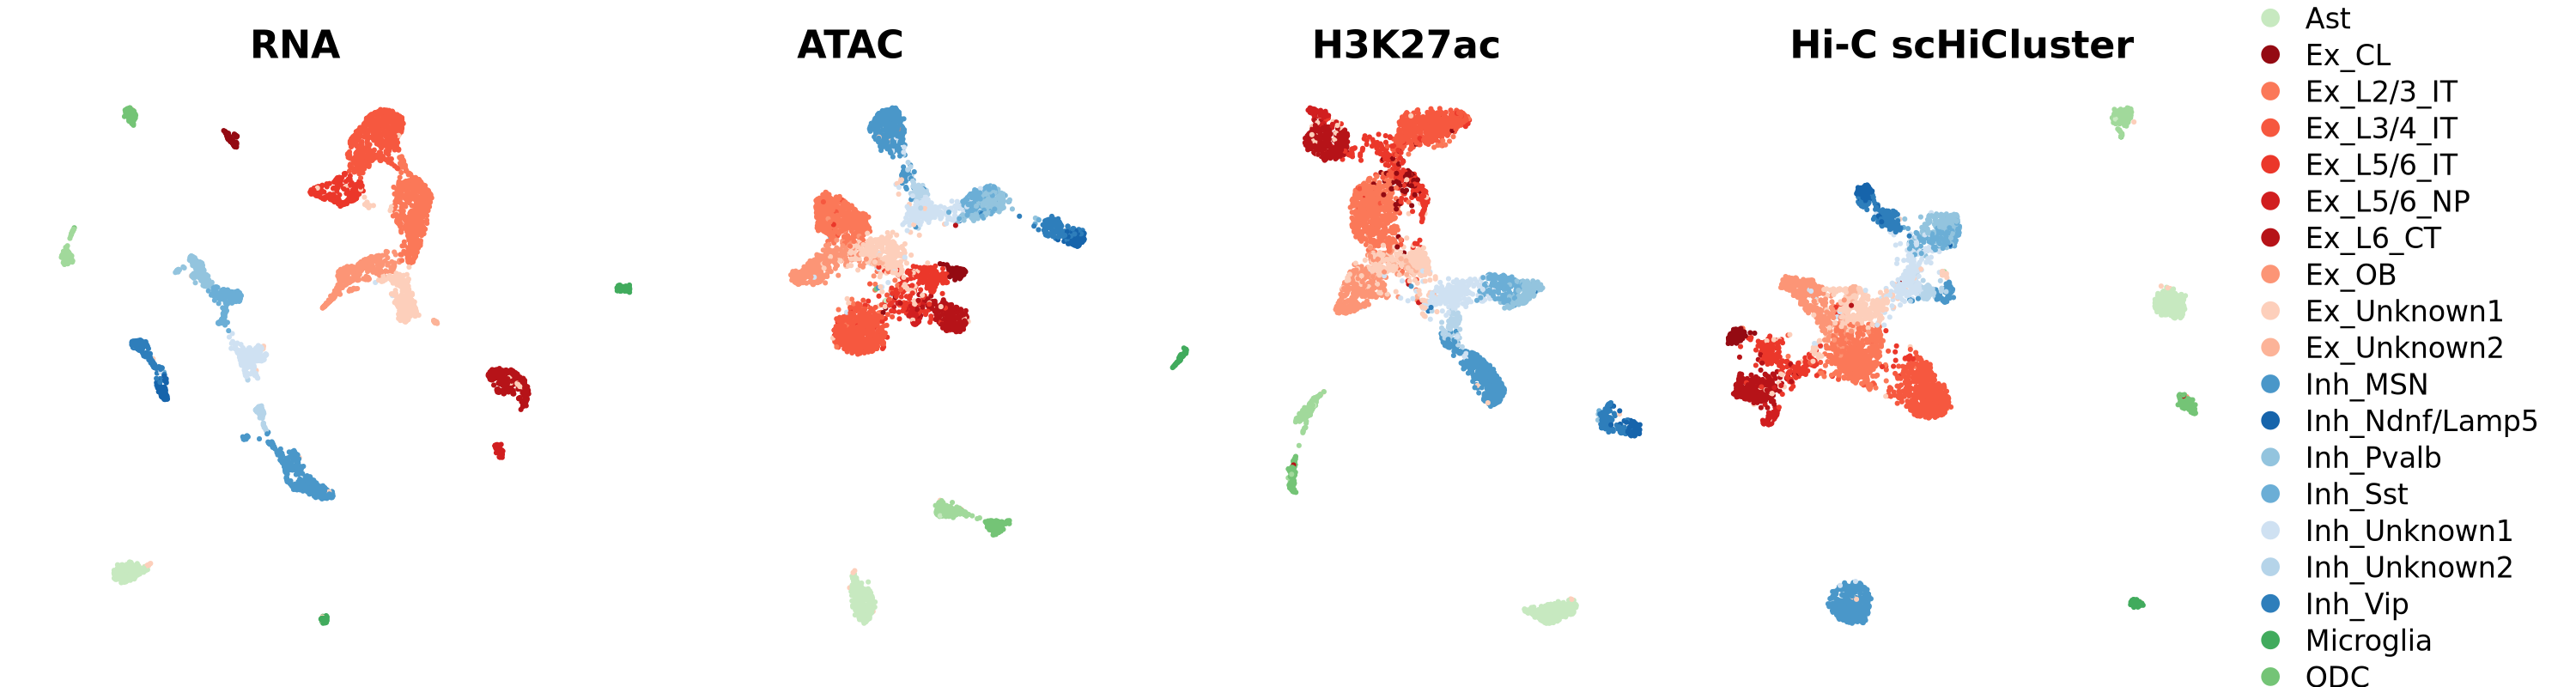

In [78]:
library(RColorBrewer)
get_optimized_colors <- function(palette, n) {
  colorRampPalette(brewer.pal(9, palette))(max(n, 9))[seq_len(n)] # 确保最小取色数
}
excitatory_colors <- get_optimized_colors("Reds", 12)[3:12]  
inhibitory_colors <- get_optimized_colors("Blues", 11)[3:12] 
glia_colors <- get_optimized_colors("Greens", 7)[3:6]     


celltype_colors <- c(
  "Ex_Unknown1" = excitatory_colors[1], 
  "Ex_Unknown2" = excitatory_colors[2],
  "Ex_OB" = excitatory_colors[3],
  "Ex_L2/3_IT" = excitatory_colors[4],
  "Ex_L3/4_IT" = excitatory_colors[5],
  "Ex_L5/6_IT" = excitatory_colors[6],
  "Ex_L5/6_NP" = excitatory_colors[7],
  "Ex_L6_CT" = excitatory_colors[8],   
  "Ex_CL" = excitatory_colors[9],
  
  # 抑制性神经元（7类）
  "Inh_Unknown1" = inhibitory_colors[1],
  "Inh_Unknown2" = inhibitory_colors[2],
  "Inh_Pvalb" = inhibitory_colors[3],
  "Inh_Sst" = inhibitory_colors[4],  
  "Inh_MSN" = inhibitory_colors[5], 
  "Inh_Vip" = inhibitory_colors[6],
  "Inh_Ndnf/Lamp5" = inhibitory_colors[7],
  
  # 胶质细胞（4类）
  "Ast" = glia_colors[1],
  "OPC" = glia_colors[2],
  "ODC" = glia_colors[3],
  "Microglia" = glia_colors[4]
)

options(repr.plot.width=15, repr.plot.height=4,repr.plot.res=200)
a = DimPlot(charm,reduction="umap",group.by = "celltype",cols = celltype_colors) + ggtitle("RNA")
b = DimPlot(charm,reduction="atac_umap",group.by = "celltype",cols = celltype_colors)+ ggtitle("ATAC")
c = DimPlot(charm,reduction="ct_umap",group.by = "celltype",cols = celltype_colors)+ ggtitle("H3K27ac")
d = DimPlot(charm,reduction="schicluster_umap",group.by = "celltype",cols = celltype_colors)+ ggtitle("Hi-C scHiCluster")

(a& NoLegend()|b& NoLegend()|c&NoLegend()|d) & NoAxes() 

In [79]:
charm %>% saveRDS("./charm.rds")

In [80]:
charm[[]] %>% write_tsv("../data/metadata/metadata.tsv")

In [81]:
charm[[]] %>% write_tsv("metadata.tsv")

In [3]:
charm <- readRDS("./charm.rds")

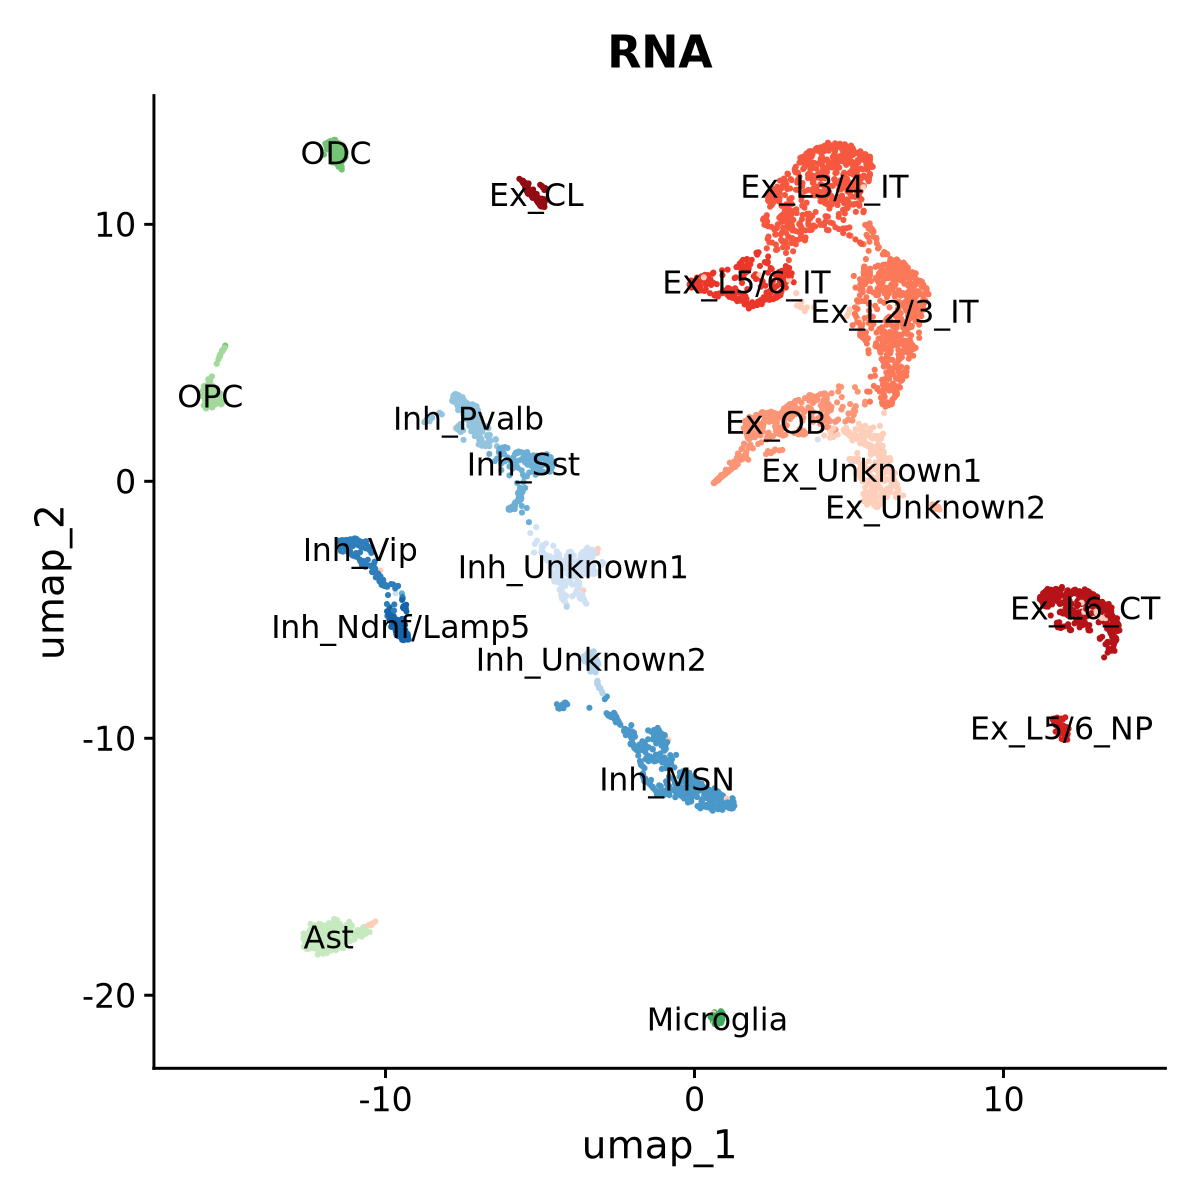

In [5]:
library(RColorBrewer)
get_optimized_colors <- function(palette, n) {
  colorRampPalette(brewer.pal(9, palette))(max(n, 9))[seq_len(n)] # 确保最小取色数
}
excitatory_colors <- get_optimized_colors("Reds", 12)[3:12]  
inhibitory_colors <- get_optimized_colors("Blues", 11)[3:12] 
glia_colors <- get_optimized_colors("Greens", 7)[3:6]     


celltype_colors <- c(
  "Ex_Unknown1" = excitatory_colors[1], 
  "Ex_Unknown2" = excitatory_colors[2],
  "Ex_OB" = excitatory_colors[3],
  "Ex_L2/3_IT" = excitatory_colors[4],
  "Ex_L3/4_IT" = excitatory_colors[5],
  "Ex_L5/6_IT" = excitatory_colors[6],
  "Ex_L5/6_NP" = excitatory_colors[7],
  "Ex_L6_CT" = excitatory_colors[8],   
  "Ex_CL" = excitatory_colors[9],
  
  # 抑制性神经元（7类）
  "Inh_Unknown1" = inhibitory_colors[1],
  "Inh_Unknown2" = inhibitory_colors[2],
  "Inh_Pvalb" = inhibitory_colors[3],
  "Inh_Sst" = inhibitory_colors[4],  
  "Inh_MSN" = inhibitory_colors[5], 
  "Inh_Vip" = inhibitory_colors[6],
  "Inh_Ndnf/Lamp5" = inhibitory_colors[7],
  
  # 胶质细胞（4类）
  "Ast" = glia_colors[1],
  "OPC" = glia_colors[2],
  "ODC" = glia_colors[3],
  "Microglia" = glia_colors[4]
)

options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=200)
a = DimPlot(charm, reduction="umap", group.by = "celltype", cols = celltype_colors,label=T) + ggtitle("RNA") + NoLegend()
a

In [9]:
Idents(charm) <- "celltype"
markers = FindMarkers(charm,ident.1= "Ex_L2/3_IT",ident.2= "Inh_Sst")

In [22]:
charm  %>% FindNeighbors(dims = 1:20) %>% FindClusters(resolution = 0.1) -> charm

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4265
Number of edges: 129039

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9792
Number of communities: 13
Elapsed time: 0 seconds


Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."
